In [ ]:
!pip install tensorflow numpy scikit-learn umap-learn matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
file_path = '/content/drive/My Drive/Project 425/final_data_features.csv'  # Update path if needed
data = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
# Check the column names of the dataset
data.columns

Index(['id', 'genre', 'audio_path', 'lyric_path', 'mfcc_1', 'mfcc_2', 'mfcc_3',
       'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
       'mfcc_11', 'mfcc_12', 'mfcc_13', 'tfidf_ai', 'tfidf_away', 'tfidf_ce',
       'tfidf_che', 'tfidf_come', 'tfidf_dans', 'tfidf_des', 'tfidf_di',
       'tfidf_don', 'tfidf_du', 'tfidf_el', 'tfidf_en', 'tfidf_es',
       'tfidf_est', 'tfidf_et', 'tfidf_feel', 'tfidf_got', 'tfidf_il',
       'tfidf_je', 'tfidf_just', 'tfidf_know', 'tfidf_la', 'tfidf_le',
       'tfidf_les', 'tfidf_let', 'tfidf_life', 'tfidf_like', 'tfidf_ll',
       'tfidf_love', 'tfidf_ma', 'tfidf_make', 'tfidf_mi', 'tfidf_ne',
       'tfidf_non', 'tfidf_oh', 'tfidf_pas', 'tfidf_pour', 'tfidf_qu',
       'tfidf_que', 'tfidf_qui', 'tfidf_se', 'tfidf_si', 'tfidf_te',
       'tfidf_time', 'tfidf_tu', 'tfidf_une', 'tfidf_ve', 'tfidf_want',
       'tfidf_yeah', 'tfidf_ça'],
      dtype='object')

In [ ]:
# Extracting the relevant MFCC and TF-IDF columns
mfcc_columns = [f"mfcc_{i}" for i in range(1, 14)]  # 13 MFCC features (from mfcc_1 to mfcc_13)
tfidf_columns = [col for col in data.columns if col.startswith('tfidf')]  # All TF-IDF related columns

# Select the features for clustering
features = data[mfcc_columns + tfidf_columns]

# Standardize the features (important for clustering)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Display the first few rows of the standardized features
scaled_features[:5]


array([[-1.65761708e-01,  1.49169746e+00, -1.74434686e+00,
        -8.90541177e-01,  1.19964363e+00, -1.14368760e+00,
        -9.95522704e-01, -1.56216680e+00, -2.29163474e-01,
        -1.54704940e+00,  1.24735716e-01, -1.37521499e+00,
        -2.73407781e-01, -2.18104309e-01, -2.87955328e-01,
        -2.56462312e-01, -2.10143669e-01, -3.35241881e-01,
        -2.99499472e-01, -2.78917157e-01, -2.05347428e-01,
        -4.61018460e-01, -2.15796138e-01, -2.68008949e-01,
        -4.04260934e-01, -2.52801355e-01, -3.38474004e-01,
        -3.39240055e-01, -3.16205790e-01, -3.16439614e-01,
        -3.00782240e-01, -3.03328549e-01, -4.26100648e-01,
        -4.26395574e-01, -4.96270640e-01, -4.01216853e-01,
        -3.37004947e-01, -3.33680727e-01, -3.24238484e-01,
        -4.16737841e-01, -3.68156416e-01,  4.74763035e+00,
        -2.75425632e-01, -3.02873573e-01, -2.67050767e-01,
        -2.79993511e-01, -2.33764559e-01, -3.45131454e-01,
        -3.16800715e-01, -2.94383269e-01, -2.76663882e-0

In [ ]:
# Update the sampling layer to use tf.random.normal
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))  # Use tf.random.normal
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import keras

# Sampling (reparameterization)
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * eps

class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z, training=True)

            # MSE reconstruction loss (works with standardized real-valued inputs)
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))

            # KL loss
            kl = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            ))

            total = recon_loss + self.beta * kl

        grads = tape.gradient(total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

def build_encoder(input_dim, latent_dim=8):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(256, activation="relu")(inp)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
    return keras.Model(inp, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_dim):
    inp = keras.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation="relu")(inp)
    x = layers.Dense(256, activation="relu")(x)
    out = layers.Dense(output_dim, activation=None)(x)  # linear output for MSE
    return keras.Model(inp, out, name="decoder")

# IMPORTANT: use float32
X = scaled_features.astype("float32")

input_dim = X.shape[1]
latent_dim = 8  # use >2 to reduce collapse risk (you can visualize with UMAP later)

encoder = build_encoder(input_dim, latent_dim)
decoder = build_decoder(latent_dim, input_dim)

vae = VAE(encoder, decoder, beta=1.0)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

vae.fit(X, epochs=50, batch_size=64, shuffle=True)


Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 1.7091 - loss: 61.1633 - reconstruction_loss: 59.4542
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 4.4430 - loss: 49.6632 - reconstruction_loss: 45.2202
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 6.0432 - loss: 46.0986 - reconstruction_loss: 40.0554
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 7.5647 - loss: 42.9414 - reconstruction_loss: 35.3767
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - kl_loss: 8.3533 - loss: 40.8314 - reconstruction_loss: 32.4782
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - kl_loss: 8.6973 - loss: 39.2501 - reconstruction_loss: 30.5528
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - kl_loss: 8.9852 - loss: 37.7804 - reconstruction_loss: 28.7952
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - kl_loss: 9.2972 - loss: 36.6279 - reconstruction_loss: 27.3307
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 9.3469 - loss: 35.6

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

z_mean, z_log_var, z = vae.encoder(X)
Z = z_mean.numpy()

print("Unique latent rows (rounded):", np.unique(np.round(Z, 6), axis=0).shape[0])

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels = kmeans.fit_predict(Z)

data["cluster"] = labels
print("Unique clusters:", np.unique(labels))
data[["id", "genre", "cluster"]].head()


Unique latent rows (rounded): 5973
Unique clusters: [0 1 2 3 4]


,id,genre,cluster
0,1001890,ambient,2
1,1001891,ambient,4
2,1002753,pop,0
3,1003648,alternative,3
4,1003654,alternative,3


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

n_unique = len(np.unique(labels))
if n_unique > 1:
    sil = silhouette_score(Z, labels)
    ch = calinski_harabasz_score(Z, labels)
    print("Silhouette:", sil)
    print("Calinski-Harabasz:", ch)
else:
    print("Only 1 cluster found. Silhouette/CH cannot be computed.")


Silhouette: 0.12102341
Calinski-Harabasz: 632.46497


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-2810819982.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(latent_features_umap[:, 0], latent_features_umap[:, 1], c='blue', cmap='viridis')


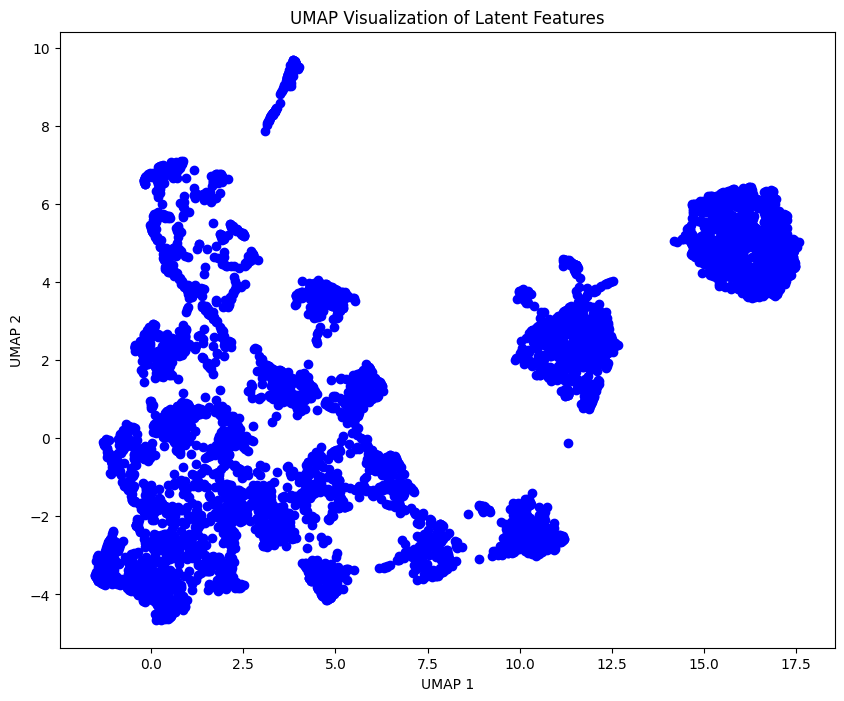

In [ ]:
import umap
import matplotlib.pyplot as plt

# Apply UMAP to reduce the dimensionality of the latent features (z_mean) to 2D
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='correlation', random_state=42)
latent_features_umap = umap_model.fit_transform(z_mean)

# Visualize the UMAP reduced latent features
plt.figure(figsize=(10, 8))
plt.scatter(latent_features_umap[:, 0], latent_features_umap[:, 1], c='blue', cmap='viridis')
plt.title("UMAP Visualization of Latent Features")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

        id  cluster  pca_kmeans_cluster
0  1001890        2                   2
1  1001891        4                   3
2  1002753        0                   1
3  1003648        3                   2
4  1003654        3                   2


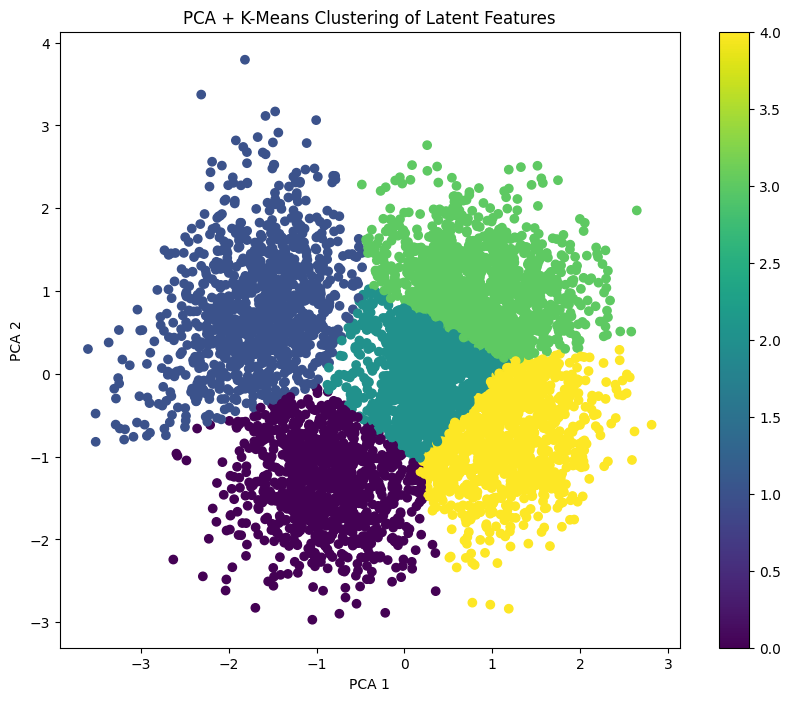

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
latent_features_pca = pca.fit_transform(z_mean)

# Apply K-Means clustering on the PCA-reduced latent features
kmeans_pca = KMeans(n_clusters=5, random_state=42)
labels_pca = kmeans_pca.fit_predict(latent_features_pca)

# Add the cluster labels from PCA + KMeans to the data
data['pca_kmeans_cluster'] = labels_pca

# Show the clusters
print(data[['id', 'cluster', 'pca_kmeans_cluster']].head())

# Visualize the PCA + KMeans clusters
plt.figure(figsize=(10, 8))
plt.scatter(latent_features_pca[:, 0], latent_features_pca[:, 1], c=labels_pca, cmap='viridis')
plt.colorbar()
plt.title("PCA + K-Means Clustering of Latent Features")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


/tmp/ipython-input-4081282489.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(latent_features_tsne[:, 0], latent_features_tsne[:, 1], c='blue', cmap='viridis')


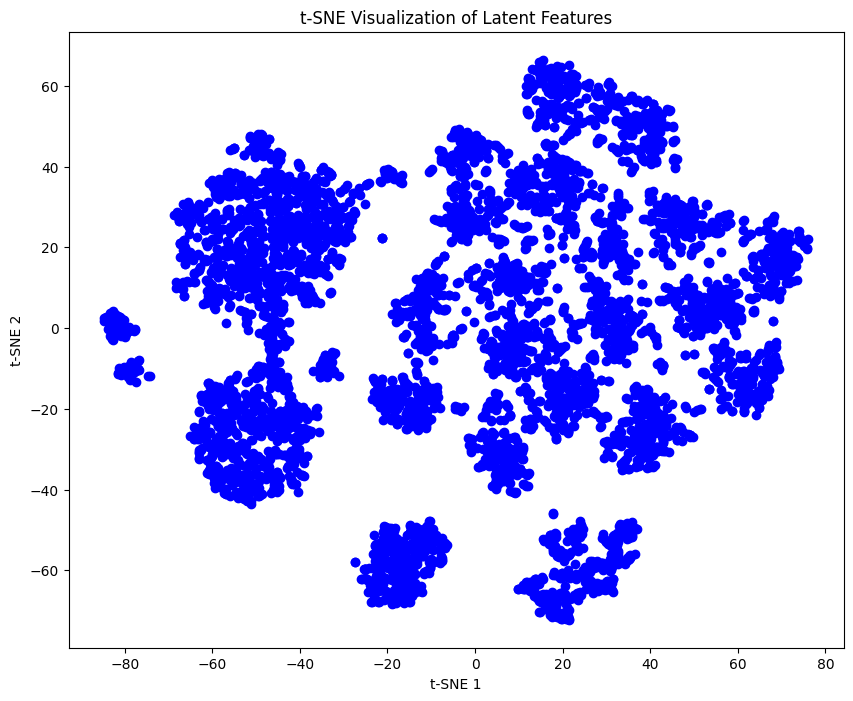

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce the dimensionality of the latent features to 2D
tsne = TSNE(n_components=2, random_state=42)
latent_features_tsne = tsne.fit_transform(z_mean)

# Visualize the t-SNE reduced latent features
plt.figure(figsize=(10, 8))
plt.scatter(latent_features_tsne[:, 0], latent_features_tsne[:, 1], c='blue', cmap='viridis')
plt.title("t-SNE Visualization of Latent Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [ ]:
# Save the data with the additional clustering results
data.to_csv("/content/drive/My Drive/Project 425/clustered_data_with_pca_tsne.csv", index=False)
print("Clustering results (PCA + KMeans, t-SNE + KMeans) saved to /content/drive/My Drive/Project 425/clustered_data_with_pca_tsne.csv")


Clustering results (PCA + KMeans, t-SNE + KMeans) saved to /content/drive/My Drive/Project 425/clustered_data_with_pca_tsne.csv
